# Step 1: Libraries and Data Loading

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.optim as optim


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict



In [2]:
qmnist = unpickle("MNIST-120k")

In [3]:
X  = qmnist['data']
y = qmnist['labels']
X.shape, y.shape

((120000, 28, 28), (120000, 1))

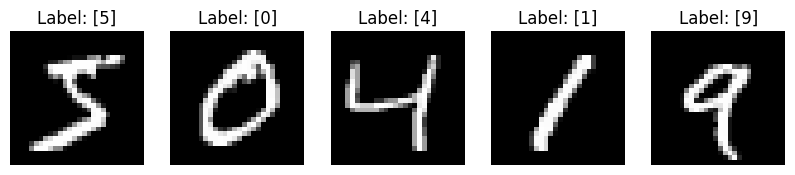

In [4]:
def plot_images(X, y, num_images=5):
    images = X.reshape(-1, 28, 28)

    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Label: {y[i]}')

plot_images(X, y)
plt.show()


# Step 2: Data Processing


##Data Normalization
We use the following formula to normalize data. The min() and max() values are the possible minimum and maximum values supported within the type of data.

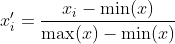

In [5]:
X = torch.tensor(qmnist['data'], dtype=torch.float32)
y = torch.tensor(qmnist['labels'], dtype=torch.long)
dataset = TensorDataset(X, y)
# confirming scale of pixel values
print('Train min=%.3f, max=%.3f' % (X.min(), X.max()))
print('Train min=%.3f, max=%.3f' % (y.min(), y.max()))

print(X.shape, y.shape)


Train min=0.000, max=255.000
Train min=0.000, max=9.000
torch.Size([120000, 28, 28]) torch.Size([120000, 1])


In [6]:
for i in range(X.shape[0]):
    X[i] = (X[i] - X[i].min()) / (X[i].max() - X[i].min())
X.shape

torch.Size([120000, 28, 28])

In [7]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_dataset)}", f"Train set ratio: {len(train_dataset) / len(dataset)*100}%")
print(f"Validation set size: {len(val_dataset)}", f"Validation set ratio: {len(val_dataset) / len(dataset)*100}%")
print(f"Test set size: {len(test_dataset)}", f"Test set ratio: {len(test_dataset) / len(dataset)*100}%")



Training set size: 84000 Train set ratio: 70.0%
Validation set size: 18000 Validation set ratio: 15.0%
Test set size: 18000 Test set ratio: 15.0%


In [8]:
# confirming scale of pixel values
print('Train min=%.3f, max=%.3f' % (X.min(), X.max()))
print('Train min=%.3f, max=%.3f' % (y.min(), y.max()))

print(X.shape, y.shape)


Train min=0.000, max=1.000
Train min=0.000, max=9.000
torch.Size([120000, 28, 28]) torch.Size([120000, 1])


#Step 3: Building the Neural Network

In [9]:
model = nn.Sequential(nn.Linear(28 * 28, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

##Define a Loss function and optimizer


Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
epochs = 15
for e in range(epochs):
    model.train()
    running_train_loss = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        labels = labels.squeeze(1)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

In [12]:
model.eval()
running_val_loss = 0
val_accuracy = 0
with torch.no_grad():
  for images, labels in val_loader:
            images = images.view(images.shape[0], -1)
            labels = labels.squeeze()

            output = model(images)
            val_loss = criterion(output, labels)
            running_val_loss += val_loss.item()

            _, top_class = torch.max(output, 1)
            equals = top_class == labels.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor))
print(f"Epoch {e+1}/{epochs}")
print(f"Training loss: {running_train_loss/len(train_loader):.4f}")
print(f"Validation loss: {running_val_loss/len(val_loader):.4f}")
print(f"Validation accuracy: {val_accuracy/len(val_loader):.4f}")

Epoch 15/15
Training loss: 0.0807
Validation loss: 0.0950
Validation accuracy: 0.9722


In [13]:
model.eval()
with torch.no_grad():
    accuracy = 0
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        _, top_class = torch.max(log_ps, 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    print(f"Final Test Accuracy: {accuracy / len(test_loader):.2f}")

Final Test Accuracy: 0.97


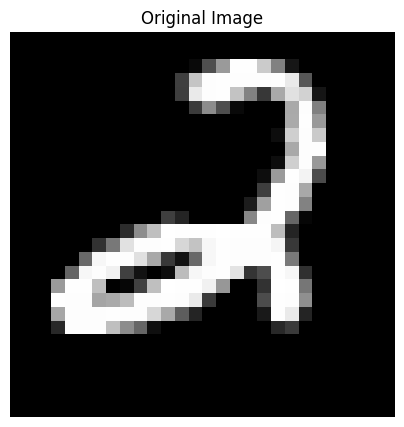

Predicted Digit: 2
True Label: tensor([2])


In [14]:
import random
val =random.randint(0,120000)
single_image = X[val]

displayed_image = single_image.reshape(28, 28)

plt.figure(figsize=(5,5))
plt.imshow(displayed_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

def test_single_image(model, image):
    image = (image - image.min()) / (image.max() - image.min())
    image = image.view(1, -1)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

prediction = test_single_image(model, single_image)
print(f"Predicted Digit: {prediction}")
print(f"True Label: {y[val]}")

In [15]:
torch.save(model.state_dict(), "mnist_model.pth")